# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
import h2o
from h2o.automl import H2OAutoML
from matplotlib import pyplot as plt
h2o.init()

warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "21.0.1" 2023-10-17 LTS; Java(TM) SE Runtime Environment (build 21.0.1+12-LTS-29); Java HotSpot(TM) 64-Bit Server VM (build 21.0.1+12-LTS-29, mixed mode, sharing)
  Starting server from /Users/hansstem/.conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/pn/k54j3srs4qj5_k6z9vslg9qh0000gn/T/tmp39xjlwq8
  JVM stdout: /var/folders/pn/k54j3srs4qj5_k6z9vslg9qh0000gn/T/tmp39xjlwq8/h2o_hansstem_started_from_python.out
  JVM stderr: /var/folders/pn/k54j3srs4qj5_k6z9vslg9qh0000gn/T/tmp39xjlwq8/h2o_hansstem_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,"21 days, 23 hours and 19 minutes"
H2O_cluster_name:,H2O_from_python_hansstem_8r2mx1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [4]:
print(len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 01:00:00'))].index
print(ind)
XTRA.drop(ind, inplace=True)
print(len(XTRA))


136245
Index([118668], dtype='int64')
136244


In [5]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Index([116916], dtype='int64')
134504
C: 
 134401
Index([116244], dtype='int64')
134400


# Data clean up

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

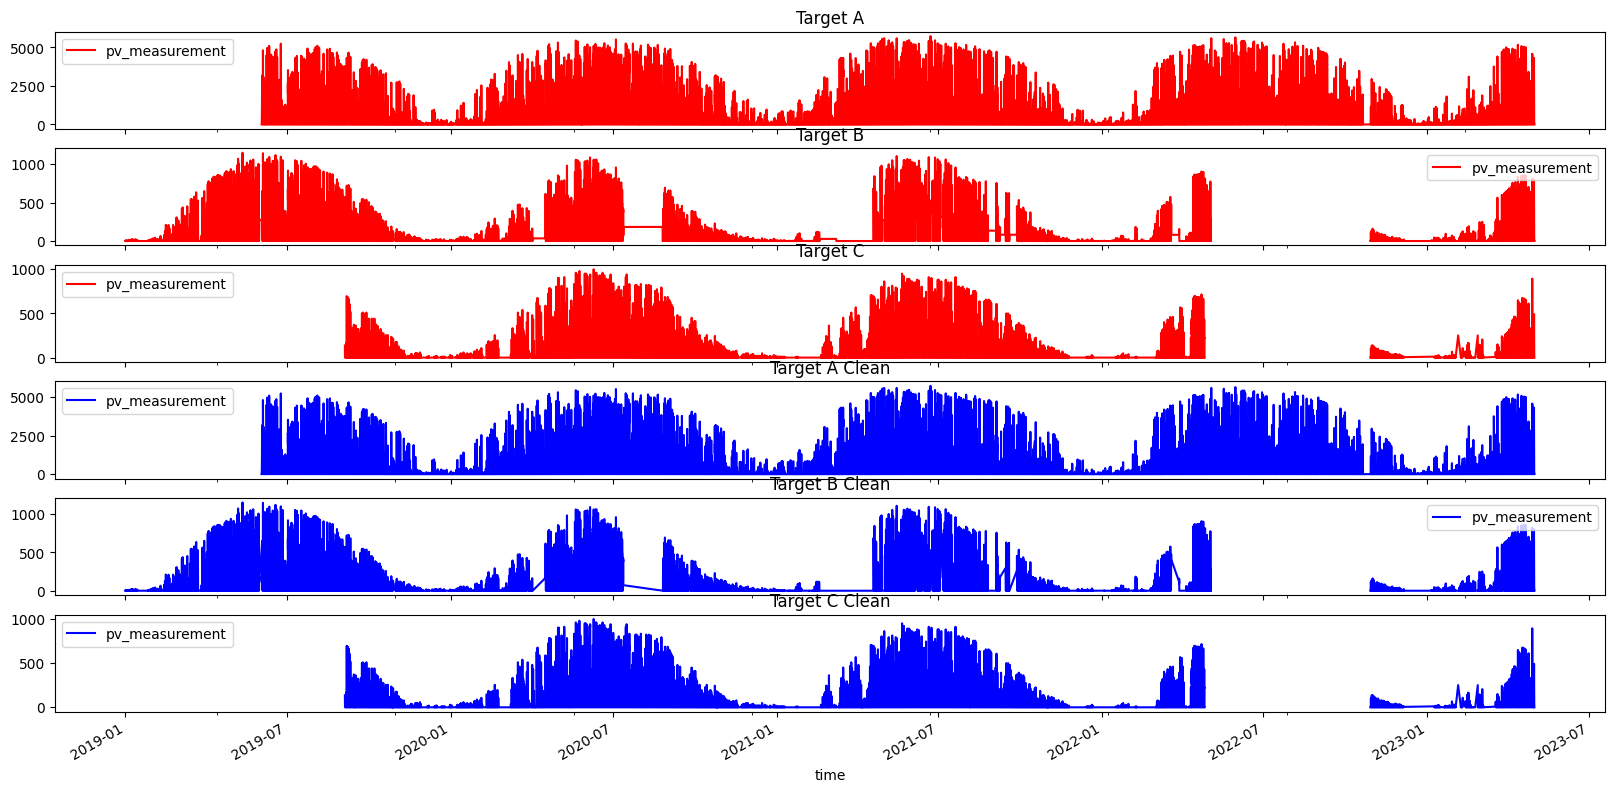

In [6]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



In [7]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [8]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))



x,y:  29667 29667
x,y:  29596 29596
x,y:  26028 26028


In [9]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))




x,y:  29667 29667
x,y:  29596 29596
x,y:  26028 26028


# Feature engineering

In [10]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DF
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DF.date_forecast_columns(X_train[i])

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DF.date_forecast_columns(X_frames_test[i])    
 

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


In [11]:
## Multiplying effective cloud coverage with clear sky radiation
from data_func.feature_engineering.combine import multiply_columns

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train)):
    A = X_train[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train[i]['clear_sky_energy_1h:J']
    AT = X_frames_test[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test[i]['clear_sky_energy_1h:J']

    X_train[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] =  multiply_columns(AT, BT)


In [12]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,4986,4588,5122
cloud_base_agl:m,1612,2025,2199
snow_density:kgm3,28527,28040,24561


In [13]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [14]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 200000, "cloud_base_agl:m": 200000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)
    print(i)


0
1
2


In [15]:
X_frames_test[1]['dew_or_rime:idx_-1']


29596    0.0
29597    0.0
29598    0.0
29599    0.0
29600    0.0
        ... 
30311    0.0
30312    0.0
30313    0.0
30314    0.0
30315    0.0
Name: dew_or_rime:idx_-1, Length: 720, dtype: float64

In [16]:

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                           ['effective_cloud_cover:p', 'total_cloud_cover:p']
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
X_train[0].describe().transpose()




# top_10_worst_features = ['precip_type_5min:idx_5', 'wind_speed_w_1000hPa:ms', 'dew_or_rime:idx_-1', 'precip_type_5min:idx_2', 'dew_or_rime:idx_1', 'snow_drift:idx', 'dew_or_rime:idx_0', 'prob_rime:p', 'precip_type_5min:idx_3', 'fresh_snow_1h:cm',
#                          'fresh_snow_3h:cm', 'snow_melt_10min:mm', 'fresh_snow_6h:cm', 'snow_depth:cm', 'precip_type_5min:idx_1',
#                          'rain_water:kgm2', 'fresh_snow_12h:cm']
top_5_worst_features = ['snow_drift:idx', 'dew_or_rime:idx_-1', 'dew_or_rime:idx_0', 'precip_type_5min:idx_5', 'precip_type_5min:idx_2'
                        ]
for i in range(len(X_train)):
    X_train[i].drop(columns=top_5_worst_features, inplace=True)
    X_frames_test[i].drop(columns=top_5_worst_features, inplace=True)

# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_10_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_10_worst_features, inplace=True)


# for i in range(len(X_train)):
#     X_train[i]['diffuse_rad:W_mean_prev_hour'] = X_train[i]['diffuse_rad:W_mean'].shift(1)
#     X_train[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_train[i]['diffuse_rad_1h:J_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad:W_mean_prev_hour'] = X_frames_test[i]['diffuse_rad:W_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_frames_test[i]['diffuse_rad_1h:J_mean'].shift(1)


X_train[0].head(10)


,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,...,week_of_year,dew_or_rime:idx_1,precip_type_5min:idx_0,precip_type_5min:idx_1,precip_type_5min:idx_3,COMB_clear_sky_energy_X_eff_cloud_cover,msl_pressure:hPa_mean,diffuse_rad:W_mean,diffuse_rad_1h:J_mean,effective_cloud_cover:p_mean
0,0,1,8.0250,1.230625,2072.600098,0.000000,0.000000,1731.949951,280.787506,0.000000,...,22,0,1,0,0,0.000000e+00,998.559448,0.000000,0.000000,99.768753
1,0,1,7.9000,1.228750,2862.512451,0.000000,0.000000,1874.849976,280.574982,0.000000,...,22,0,1,0,0,0.000000e+00,997.471863,0.000000,0.000000,99.937500
2,0,1,8.0125,1.224750,1722.612549,0.000000,0.000000,1619.137451,280.787506,0.000000,...,23,0,1,0,0,-0.000000e+00,995.843750,0.000000,0.000000,100.000000
3,0,1,8.3125,1.223250,1452.912476,104.324997,0.375000,1415.487549,281.362488,0.150000,...,23,0,1,0,0,-0.000000e+00,995.290649,0.075000,131.693756,100.000000
4,0,0,8.6625,1.222500,1162.887451,16234.075195,11.550000,1028.612549,281.924988,5.987500,...,23,0,1,0,0,1.227702e+05,994.700012,3.031250,5587.980957,96.025002
5,0,0,8.9000,1.219875,924.237488,89749.539062,42.187500,756.312500,282.375000,22.562500,...,23,0,1,0,0,1.569495e+06,994.406250,12.856250,28603.898438,89.956253
6,0,0,9.1375,1.217000,806.187500,239058.906250,93.324997,709.412476,282.812500,44.762501,...,23,0,1,0,0,2.683436e+06,994.484375,33.312500,83127.843750,93.162506
7,0,0,9.1000,1.216750,777.125000,446333.937500,155.762512,576.025024,282.712494,69.500000,...,23,0,1,0,0,3.336346e+06,994.856201,48.025002,146409.109375,95.550003
8,0,0,8.8000,1.218000,888.700012,678951.000000,221.375000,534.387512,282.174988,83.550003,...,23,0,1,0,0,1.103295e+06,995.456299,50.231251,176858.437500,98.987503
9,1,0,8.6375,1.219125,847.424988,920296.187500,292.537506,494.362488,281.937500,111.724998,...,23,0,1,0,0,1.299917e+06,996.228149,60.399998,199159.734375,98.587502


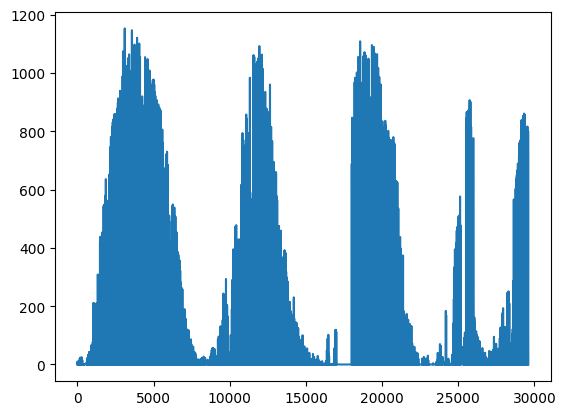

In [17]:

# Trengs å gjøre for å få h2 til å funke
def merge(df1, df2):
    return pd.merge(df1, df2, left_index=True, right_index=True)

x_train_a = merge(X_train[0], Y_train[0])
x_train_b = merge(X_train[1], Y_train[1])
x_train_c = merge(X_train[2], Y_train[2])

plt.plot(Y_train[1])



In [18]:



# Data set A, B and C to H2O

def data_to_h2o(x_train, y_train, x_test):
  
    x_train_h2o = h2o.H2OFrame(x_train)
    y_train = y_train.to_frame()
    y_train_h2o = h2o.H2OFrame(y_train)
    x_test_h2o = h2o.H2OFrame(x_test)
  
    return x_train_h2o, y_train_h2o, x_test_h2o



x_train_a_h2o, y_train_a_h2o, x_test_a_h2o = data_to_h2o(x_train_a, Y_train[0], X_frames_test[0])
x_train_b_h2o, y_train_b_h2o, x_test_b_h2o = data_to_h2o(x_train_b, Y_train[1], X_frames_test[1])
x_train_c_h2o, y_train_c_h2o, x_test_c_h2o = data_to_h2o(x_train_c, Y_train[2], X_frames_test[2])
y_train_a_h2o.head()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


pv_measurement
0
0
0
0
19.36
251.02
263.78
522.72
904.42
1238.82


# Training the model

In [19]:
print(y_train_a_h2o)
aml_a = H2OAutoML(max_models=10, seed=69, max_runtime_secs=3600)
aml_b = H2OAutoML(max_models=10, seed=69, max_runtime_secs=3600)
aml_c = H2OAutoML(max_models=10, seed=69, max_runtime_secs=3600)

aml_a.train(x=x_train_a_h2o.columns, y=y_train_a_h2o.columns[0], training_frame=x_train_a_h2o)


  pv_measurement
            0
            0
            0
            0
           19.36
          251.02
          263.78
          522.72
          904.42
         1238.82
[29667 rows x 1 column]

AutoML progress: |
09:46:31.338: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/10
# GBM base models (used / total),4/6
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [20]:
aml_b.train(x=x_train_b_h2o.columns, y=y_train_b_h2o.columns[0], training_frame=x_train_b_h2o)


AutoML progress: |
09:49:45.250: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/10
# GBM base models (used / total),5/6
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [21]:
aml_c.train(x=x_train_c_h2o.columns, y=y_train_c_h2o.columns[0], training_frame=x_train_c_h2o)


AutoML progress: |
09:52:15.805: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/10
# GBM base models (used / total),4/6
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


# Evaluate training

In [22]:
lb = aml_a.leaderboard
lb.head(rows=lb.nrows) 


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20231107_94631,373.302,139355,174.156,nan,139355
GBM_4_AutoML_1_20231107_94631,377.197,142278,174.924,nan,142278
StackedEnsemble_BestOfFamily_1_AutoML_1_20231107_94631,377.295,142351,175.304,nan,142351
GBM_3_AutoML_1_20231107_94631,382.819,146550,179.356,nan,146550
GBM_2_AutoML_1_20231107_94631,388.619,151025,183.453,nan,151025
GBM_grid_1_AutoML_1_20231107_94631_model_1,392.257,153866,184.257,nan,153866
GBM_5_AutoML_1_20231107_94631,394.604,155712,187.197,nan,155712
GBM_1_AutoML_1_20231107_94631,405.316,164281,191.771,nan,164281
DRF_1_AutoML_1_20231107_94631,412.922,170505,191.987,0.741622,170505
XRT_1_AutoML_1_20231107_94631,414.282,171629,192.954,0.747959,171629


In [23]:
lb = aml_b.leaderboard
lb.head(rows=lb.nrows)


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_2_20231107_94945,54.689,2990.88,21.6751,nan,2990.88
GBM_4_AutoML_2_20231107_94945,55.6514,3097.08,21.8801,nan,3097.08
StackedEnsemble_BestOfFamily_1_AutoML_2_20231107_94945,55.6804,3100.31,21.971,nan,3100.31
GBM_3_AutoML_2_20231107_94945,55.7793,3111.33,22.0689,nan,3111.33
GBM_5_AutoML_2_20231107_94945,56.5823,3201.55,22.9864,nan,3201.55
GBM_grid_1_AutoML_2_20231107_94945_model_1,56.8183,3228.32,22.6566,nan,3228.32
GBM_2_AutoML_2_20231107_94945,56.8367,3230.42,22.693,nan,3230.42
GBM_1_AutoML_2_20231107_94945,59.7479,3569.82,23.9764,nan,3569.82
DRF_1_AutoML_2_20231107_94945,60.5907,3671.24,23.8587,0.770183,3671.24
XRT_1_AutoML_2_20231107_94945,60.7875,3695.12,24.1678,0.794067,3695.12


In [24]:
lb = aml_c.leaderboard
lb.head(rows=lb.nrows)


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_3_20231107_95215,44.8327,2009.97,17.869,nan,2009.97
GBM_3_AutoML_3_20231107_95215,45.5611,2075.81,18.2258,nan,2075.81
StackedEnsemble_BestOfFamily_1_AutoML_3_20231107_95215,45.588,2078.27,18.2703,nan,2078.27
GBM_4_AutoML_3_20231107_95215,45.6958,2088.1,18.0196,nan,2088.1
GBM_2_AutoML_3_20231107_95215,46.0357,2119.28,18.5189,nan,2119.28
GBM_5_AutoML_3_20231107_95215,46.3154,2145.11,18.8673,nan,2145.11
GBM_grid_1_AutoML_3_20231107_95215_model_1,47.0223,2211.09,18.933,nan,2211.09
DRF_1_AutoML_3_20231107_95215,48.224,2325.56,19.1124,0.713841,2325.56
XRT_1_AutoML_3_20231107_95215,48.2521,2328.27,19.2482,0.719384,2328.27
GBM_1_AutoML_3_20231107_95215,49.2451,2425.08,20.1088,nan,2425.08


In [25]:
X_frames_test[1].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
is_day:idx,720.0,0.773611,0.418785,0.0,1.0,1.0,1.0,1.0
is_in_shadow:idx,720.0,0.223611,0.416954,0.0,0.0,0.0,0.0,1.0
absolute_humidity_2m:gm3,720.0,8.214131,2.18356,3.2,6.69375,8.0625,9.98125,13.7
air_density_2m:kgm3,720.0,1.234833,0.0307,1.1565,1.2125,1.240375,1.26,1.299
ceiling_height_agl:m,720.0,52316.589844,85362.03125,46.450001,1218.537506,3136.125,58573.173828,200000.0
...,...,...,...,...,...,...,...,...
COMB_clear_sky_energy_X_eff_cloud_cover,720.0,40760122.545744,67633300.442282,-0.0,-0.0,2394805.140137,54585797.332287,298217400.0
msl_pressure:hPa_mean,720.0,1011.486206,9.719884,981.162476,1006.146896,1015.159363,1018.587524,1024.131226
diffuse_rad:W_mean,720.0,99.844749,107.510742,0.0,4.540625,61.0,171.618748,382.4375
diffuse_rad_1h:J_mean,720.0,359440.28125,382746.25,0.0,22759.603516,230995.53125,594651.03125,1364992.625


# Make predictions

In [26]:
y_pred_a = aml_a.leader.predict(x_test_a_h2o)
y_pred_b = aml_b.leader.predict(x_test_b_h2o)
y_pred_c = aml_c.leader.predict(x_test_c_h2o)
y_pred_a = y_pred_a.as_data_frame()
y_pred_b = y_pred_b.as_data_frame()
y_pred_c = y_pred_c.as_data_frame()


y_pred_a = y_pred_a.multiply(X_frames_test[0]['is_day:idx'].values, axis=0)
y_pred_b = y_pred_b.multiply(X_frames_test[1]['is_day:idx'].values, axis=0)
y_pred_c = y_pred_c.multiply(X_frames_test[2]['is_day:idx'].values, axis=0)


stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [27]:

y_pred = pd.concat([y_pred_a, y_pred_b, y_pred_c], axis=0, ignore_index=True)


,predict
0,0.000000
1,0.000000
2,0.000000
3,97.379657
4,563.718260
5,1953.830541
6,2407.249507
7,2631.184669
8,2996.415469
9,3083.056887


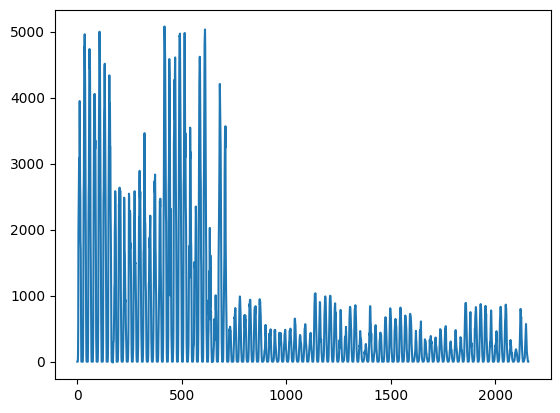

In [28]:
plt.plot(y_pred)

y_pred.head(40)


In [29]:
varimp = aml_a.varimp(use_pandas=True)
print(varimp)


                              DeepLearning_1     GLM_1     GBM_5     GBM_2  \
diffuse_rad_1h:J_mean               0.018323  0.051995  0.068207  0.038272   
clear_sky_energy_1h:J               0.015722  0.033729  0.003862  0.003266   
estimated                           0.023935  0.038406  0.003786  0.002063   
diffuse_rad_1h:J                    0.013572  0.016090  0.004480  0.004700   
ceiling_height_agl:m                0.006782  0.010836  0.001249  0.001552   
wind_speed_w_1000hPa:ms             0.023197  0.000318  0.000000  0.000000   
precip_type_5min:idx_1              0.011261  0.004425  0.000091  0.000054   
dew_or_rime:idx_1                   0.009936  0.000912  0.000000  0.000000   
precip_type_5min:idx_0              0.018685  0.005085  0.000394  0.000566   
is_in_shadow:idx                    0.015568  0.000022  0.000033  0.000002   
snow_depth:cm                       0.016232  0.001681  0.001130  0.000518   
precip_type_5min:idx_3              0.015212  0.002278  0.000009

# Create submission

(2160, 1)

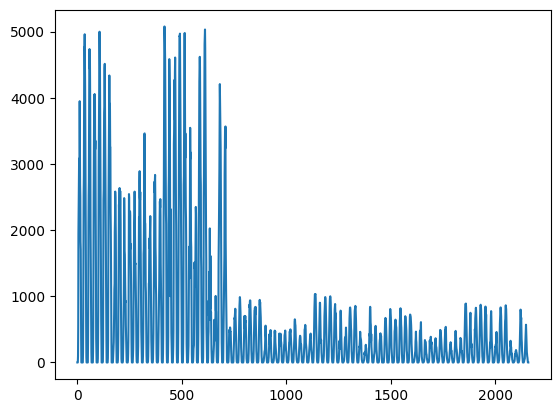

In [39]:
for i in range(len(y_pred)):
    if y_pred['predict'].iloc[i] < 0:
        y_pred['predict'].iloc[i] = 0


plt.plot(y_pred)



In [40]:
y_pred.shape


(2160, 1)

In [38]:
test = pd.read_csv('../data/test.csv')
test['prediction'] = y_pred['predict']
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_h2o.csv', index=False)
